# Comparison of two-canyon runs

* All experiments have 3 runs to get a mean curve (except aug01, I eliminated run that does weird things).
* Parameters can be found on google drive sheet lab_speadsheets/exp_list

Using calibration from July 6th (closest calibration when all probes were connected) and also the one on the 9th Aug (closest to exeriments) to check how it affects density change in the canyon heads.


In [1]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
#import seaborn as sns
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools


In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(15, color=col, linestyle=':')
    ax.axvline(21.0+15, color=col, linestyle=':')
    ax.axvline(71.0+15, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [5]:
# Dictionaries:

T01 = {"date": "31Jul19",
       "Nsb": 1.23 ,
       "Nshelf": 1.5,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,''
       "dir": '../experiments/exp_31jul19/',
       "run_files":['06_experiment1.mat','09_experiment2.mat','12_experiment3.mat'],
       "color":'mediumseagreen',
       "rho_top":[1.01706,1.01775,1.01782],
       "rho_sb":[1.02405,1.02349,1.02401],
       "rho_bot":[1.03744,1.03791,1.03715],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'09Aug19',
       }
T02 = {"date": "01Aug19",
       "Nsb": 1.03 ,
       "Nshelf": 1.02,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 2,''
       "dir": '../experiments/exp_01aug19/',
       "run_files":['06_experiment1.mat','09_experiment2.mat','13_experiment3.mat'],
       "color":'darkcyan',
       "rho_top":[1.01167,1.01238,1.01240],
       "rho_sb":[1.01470,1.01553,1.01542],
       "rho_bot":[1.02617,1.02569,1.02610],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'09Aug19',
       }
T03 = {"date": "05Aug19",
       "Nsb": 0.92 ,
       "Nshelf": 1.2,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,''
       "dir": '../experiments/exp_05aug19/',
       "run_files":['05_experiment1.mat','07_experiment2.mat','09_experiment3.mat'],
       "color":'darkslateblue',
       "rho_top":[1.00764,1.00828,np.nan],
       "rho_sb":[1.01184,1.01273,np.nan],
       "rho_bot":[1.01819,1.01842,np.nan],
       "hsb":2.85,
       "hbot":9.45,
       "calibration":'09Aug19',
       }

T04 = {"date": "07Aug19",
       "Nsb": 1.46 ,
       "Nshelf": 1.47,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 4,
       "dir": '../experiments/exp_07aug19/',
       "run_files":['04_experiment1.mat','07_experiment2.mat','09_experiment3.mat', '10_experiment4.mat'],
       "color":'darkmagenta',
       "rho_top":[1.00977,1.00967,1.01110,np.nan],
       "rho_sb":[1.01612,1.01680,1.01617,np.nan],
       "rho_bot":[1.02616,1.02611,1.02593,np.nan],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'09Aug19',
       }

T05 = {"date": "08Aug19",
       "Nsb": 1.46 ,
       "Nshelf": 1.45,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,
       "dir": '../experiments/exp_08aug19/',
       "run_files":['04_experiment1.mat','09_experiment3.mat'],#,'07_experiment2.mat'],
       "color":'plum',
       "rho_top":[1.01740,1.01781,np.nan],
       "rho_sb":[1.02351,1.02408,np.nan],
       "rho_bot":[1.03658,1.03651,np.nan],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'09Aug19',
       }
T06 = {"date": "10Aug19",
       "Nsb": 1.81 ,
       "Nshelf": 1.81,
       "fo": 0.8 ,
       "U":0.5 ,
       "run_num": 3,
       "dir": '../experiments/exp_10aug19/',
       "run_files":['06_experiment1.mat','08_experiment2.mat'],#,'11_experiment3.mat'],
       "color":'coral',
       "rho_top":[1.01580,1.01575,1.01607],
       "rho_sb":[1.02557,1.02362,1.02415],
       "rho_bot":[1.04029,1.04106,1.04006],
       "hsb":2.85,
       "hbot":9.45,
       "calibration":'09Aug19',
       }

T07 = {"date": "13Aug19",
       "Nsb": 1.47 ,
       "Nshelf": 1.47,
       "fo": 0.8 ,
       "U":0.5 ,
       "run_num": 3,
       "dir": '../experiments/exp_13aug19/',
       "run_files":['05_experiment1.mat','08_experiment2.mat','11_experiment3.mat'],
       "color":'orange',
       "rho_top":[1.01008,1.01017,np.nan],
       "rho_sb":[1.01602,1.01706,np.nan],
       "rho_bot":[1.02626,1.02621,np.nan],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'09Aug19',
       }

T08 = {"date": "15Aug19",
       "Nsb": 1.88 ,
       "Nshelf": 1.88,
       "fo": 0.8 ,
       "U":0.5 ,
       "run_num": 3,
       "dir": '../experiments/exp_15aug19/',
       "run_files":['04_experiment1.mat','08_experiment2.mat','12_experiment3.mat'],
       "color":'brown',
       "rho_top":[1.01799,1.02028,np.nan],
       "rho_sb":[1.02975,1.02919,np.nan],
       "rho_bot":[1.04902,1.04798,np.nan],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'17Aug19',
       }
T09 = {"date": "17Aug19",
       "Nsb": 1.55 ,
       "Nshelf": 1.55,
       "fo": 0.5 ,
       "U":0.25 ,
       "run_num": 3,
       "dir": '../experiments/exp_17aug19/',
       "run_files":['05_experiment1.mat','09_experiment2.mat','13_experiment3.mat'],
       "color":'gray',
       "rho_top":[1.01560,1.01730,1.01782],
       "rho_sb":[1.02407,1.02391,1.02408],
       "rho_bot":[1.04209,1.04105,1.04083],
       "hsb":2.9,
       "hbot":9.5,
       "calibration":'17Aug19',
       }
T10 = {"date": "18Aug19",
       "Nsb": 1.9 ,
       "Nshelf": 1.9,
       "fo": 0.7 ,
       "U":0.375 ,
       "run_num": 1,
       "dir": '../experiments/exp_18aug19/',
       "run_files":['04_experiment1.mat'],
       "color":'cornflowerblue',
       "rho_top":[1.01502],
       "rho_sb":[1.02586],
       "rho_bot":[1.04188],
       "hsb":2.95,
       "hbot":9.6,
       "calibration":'17Aug19',
       }
T11 = {"date": "18Aug19",
       "Nsb": 1.65 ,
       "Nshelf": 1.65,
       "fo": 0.7 ,
       "U":0.5 ,
       "run_num": 1,
       "dir": '../experiments/exp_18aug19/',
       "run_files":['07_experiment2.mat'],
       "color":'slategrey',
       "rho_top":[1.01728],
       "rho_sb":[1.02490],
       "rho_bot":[1.04160],
       "hsb":2.95,
       "hbot":9.6,
       "calibration":'17Aug19',
       }
T12 = {"date": "18Aug19",
       "Nsb": 1.65 ,
       "Nshelf": 1.65,
       "fo": 0.7 ,
       "U":0.625 ,
       "run_num": 1,
       "dir": '../experiments/exp_18aug19/',
       "run_files":['11_experiment3.mat'],
       "color":'navy',
       "rho_top":[1.01750],
       "rho_sb":[1.02514],
       "rho_bot":[1.04117],
       "hsb":2.95,
       "hbot":9.6,
       "calibration":'17Aug19',
       }

In [6]:
exp_dicts = [T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']
exp_Norder = [T02,T03,T05,T04,T01,T07,T06,T09,T08,T10,T11,T12]

### READINGS

../experiments/exp_31jul19/06_experiment1.mat
../experiments/exp_31jul19/09_experiment2.mat
../experiments/exp_31jul19/12_experiment3.mat
../experiments/exp_01aug19/06_experiment1.mat
../experiments/exp_01aug19/09_experiment2.mat
../experiments/exp_01aug19/13_experiment3.mat
../experiments/exp_05aug19/05_experiment1.mat
../experiments/exp_05aug19/07_experiment2.mat
../experiments/exp_05aug19/09_experiment3.mat
../experiments/exp_07aug19/04_experiment1.mat
../experiments/exp_07aug19/07_experiment2.mat
../experiments/exp_07aug19/09_experiment3.mat
../experiments/exp_07aug19/10_experiment4.mat
../experiments/exp_08aug19/04_experiment1.mat
../experiments/exp_08aug19/09_experiment3.mat
../experiments/exp_10aug19/06_experiment1.mat
../experiments/exp_10aug19/08_experiment2.mat
../experiments/exp_13aug19/05_experiment1.mat
../experiments/exp_13aug19/08_experiment2.mat
../experiments/exp_13aug19/11_experiment3.mat
../experiments/exp_15aug19/04_experiment1.mat
../experiments/exp_15aug19/08_expe

Text(0.5,0,'time / s')

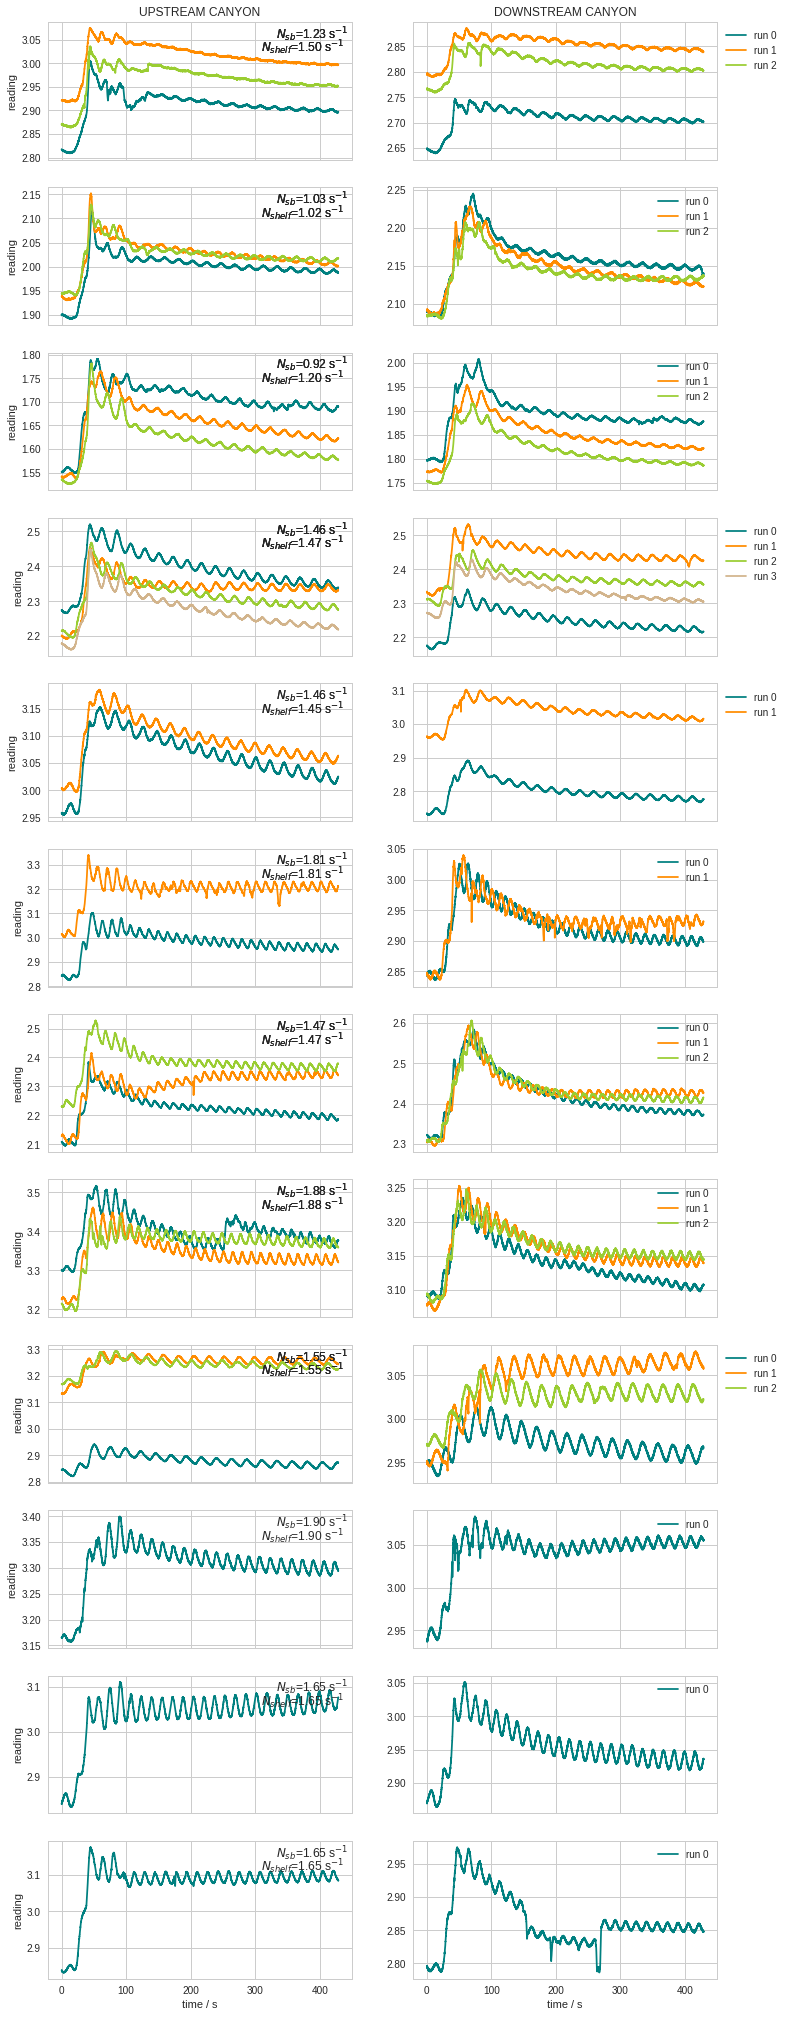

In [7]:
fig, ax = plt.subplots(exp_num, 2, figsize=(12,exp_num*3), sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')

for exp, kk in zip(exp_dicts, range(exp_num)):
    
    for ii, col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        print(filepath)
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        ax[kk,0].plot(time,P1,'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time,P2,'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.75,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.7,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
       
    ax[kk,0].set_ylabel('reading')
    ax[kk,1].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')


### Density change from initial value

Using calibration August 09 and August 17:

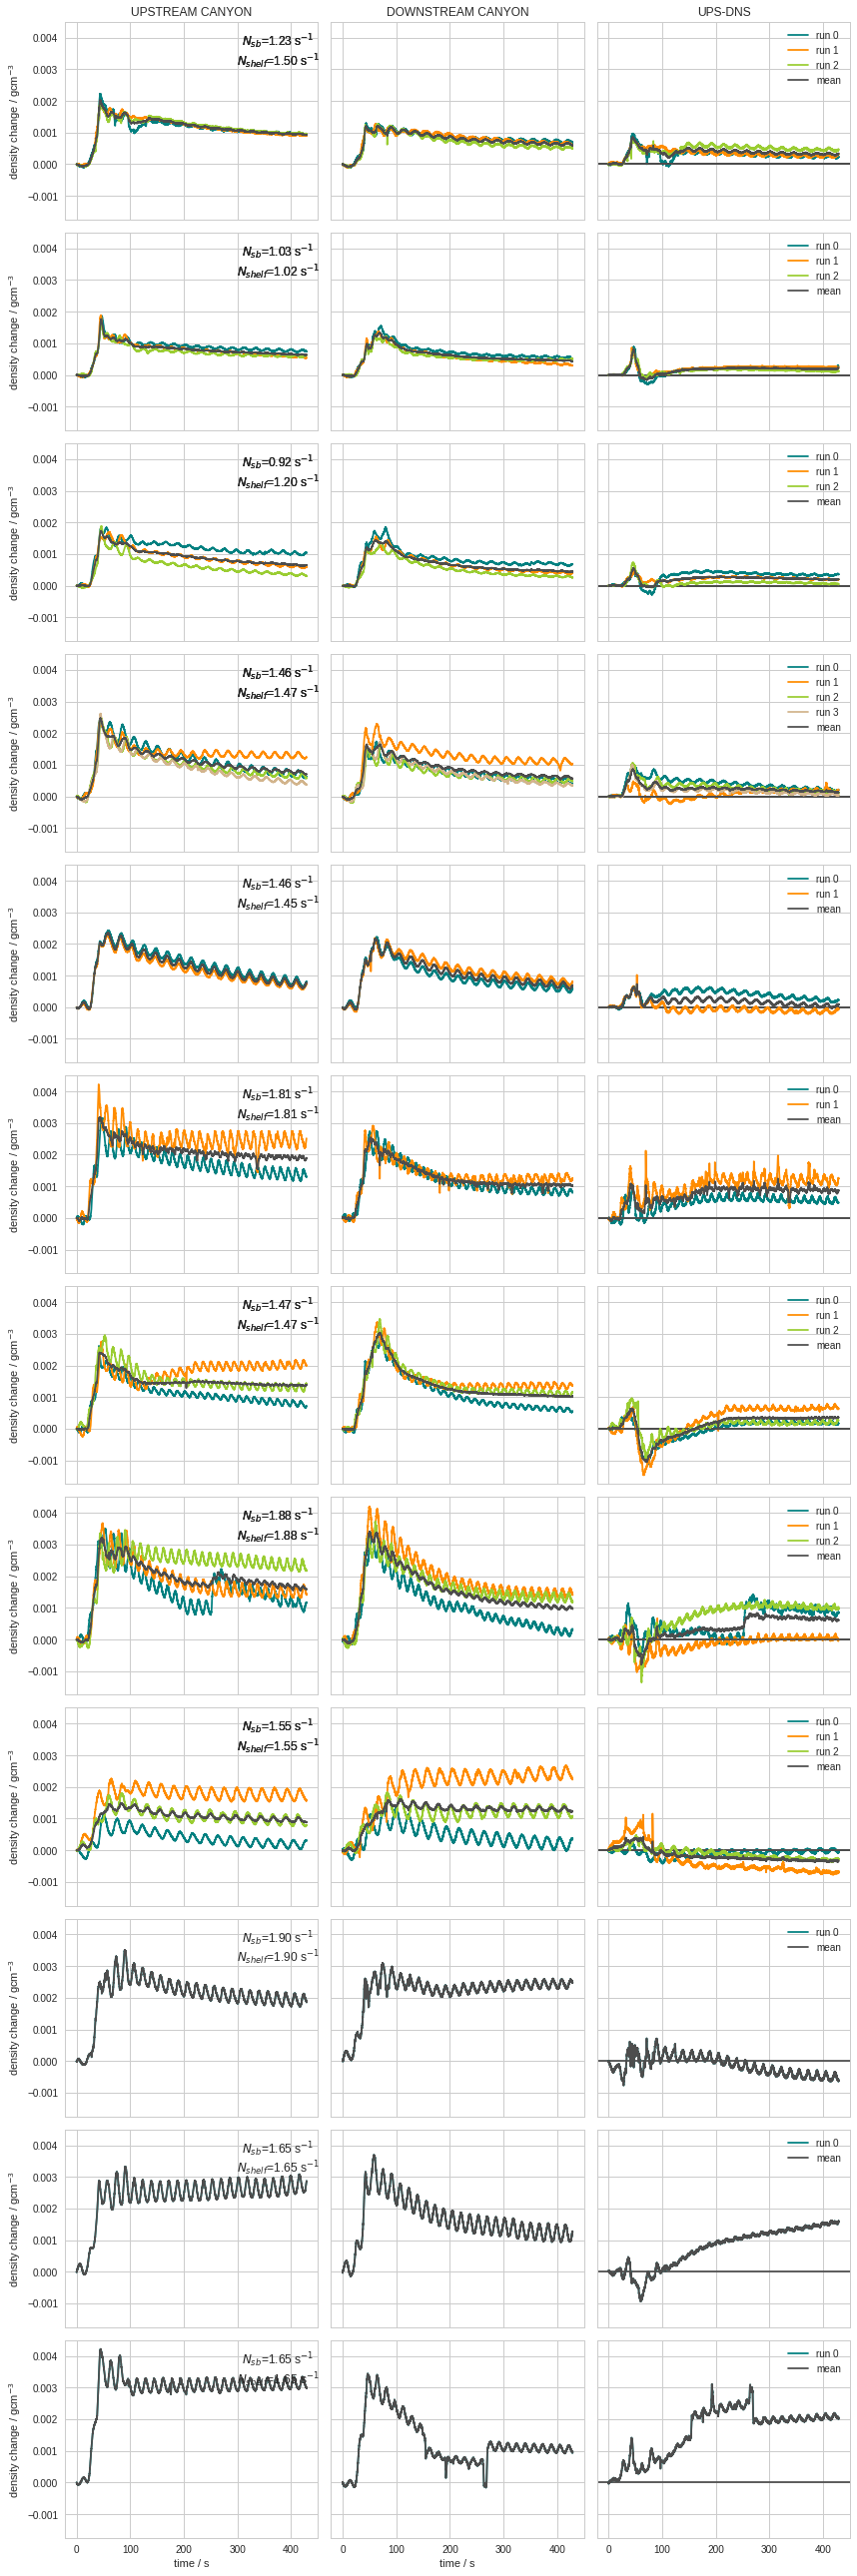

In [8]:
fig, ax = plt.subplots(exp_num, 3, figsize=(12,exp_num*3), sharey=True, sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')
ax[0,2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    for ii,col in zip(range(len(exp['run_files'])),colors):
         
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        ax[kk,0].plot(time, dens1-dens1[0],'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time, dens2-dens2[0],'-',color=col, label='run %d' %ii)
        ax[kk,2].axhline(0, color='0.3')
        ax[kk,2].plot(time, (dens1-dens1[0])-(dens2-dens2[0]),'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.70,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.68,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    ax[kk,0].plot(time, avg1/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,1].plot(time, avg2/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,2].plot(time, avg3/(len(exp['run_files'])),'-',color='0.3', label='mean')    
    ax[kk,0].set_ylabel('density change / gcm$^{-3}$')
    ax[kk,2].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')
plt.tight_layout()

### Comparison average runs

Text(0.5,0,'time / s')

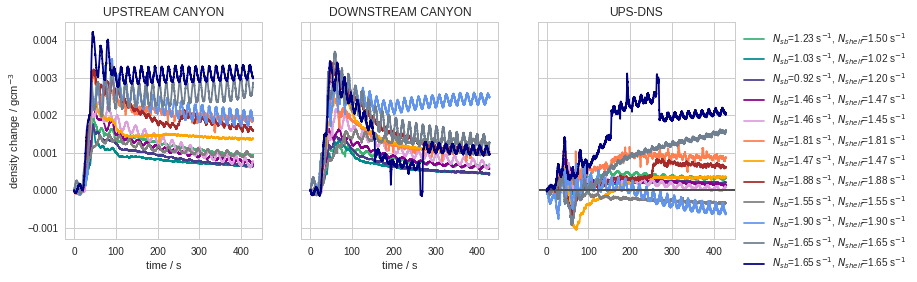

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True, sharex=True)

ax[0].set_title('UPSTREAM CANYON')
ax[1].set_title('DOWNSTREAM CANYON')
ax[2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
         
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        ax[2].axhline(0, color='0.3')
        label = '$N_{sb}$=%1.2f s$^{-1}$, $N_{shelf}$=%1.2f s$^{-1}$' %(exp["Nsb"],exp["Nshelf"])
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[0].plot(time, avg1/(len(exp['run_files'])),'-',color=exp['color'], label=label)
    ax[1].plot(time, avg2/(len(exp['run_files'])),'-',color=exp["color"], label=label)
    ax[2].plot(time, avg3/(len(exp['run_files'])),'-',color=exp["color"], label=label)    
    ax[0].set_ylabel('density change / gcm$^{-3}$')
    ax[2].legend(bbox_to_anchor=(1,1))

ax[0].set_xlabel('time / s')
ax[1].set_xlabel('time / s')


### Plots arranged by $N_{shelf}$ and $f$

Plotting mean upstream, mean downstream and mean difference filtered using salish sea filter_timeseries with window win = int(T/dt) where T is the inertial period and dt the time between conduino samples.  

In [10]:
def filter_timeseries(record, winlen=39):
    
    '''as in filter_timesies in salish sea tidetools.py without doodson option'''
    
    filtered = record.copy()
    record_length = record.shape[0]
    w = (winlen - 1) // 2
    weight = np.zeros(w, dtype=int)
    weight[:] = 1
    centerval = 1
    
    #Loop through record
    for i in range(record_length):
        
        # Adjust window length for end cases
        W = min(i, w, record_length-i-1)
        Weight = weight[:W]
        Weight = np.append(Weight[::-1], np.append(centerval, Weight))
        if sum(Weight) != 0:
            Weight = (Weight/sum(Weight))
        
        # Expand weight dims so it can operate on record window
        for dim in range(record.ndim - 1):
            Weight = Weight[:, np.newaxis]
        
        # Apply mean over window length
        if W > 0:
            filtered[i, ...] = np.sum(record[i-W:i+W+1, ...] * Weight, axis=0)
        else:
            filtered[i, ...] = record[i, ...]
    
    return filtered


12.566370614359172
12.566370614359172
12.566370614359172
12.566370614359172
12.566370614359172
7.853981633974483
7.853981633974483
12.566370614359172
7.853981633974483
8.975979010256552
8.975979010256552
8.975979010256552


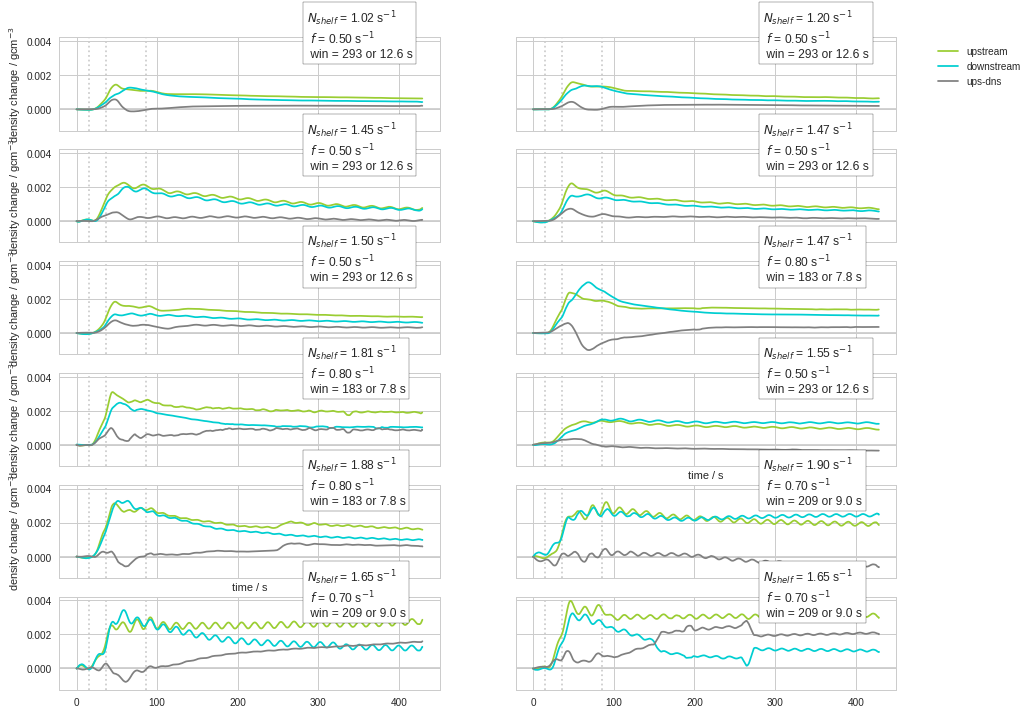

In [11]:
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(15,12), sharey=True, sharex=True)

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]

for exp, kk, ax in zip(exp_Norder, range(exp_num), axs):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
         
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
     
    inertial_period = 1/((exp["fo"])/(2*np.pi))
    win = int(inertial_period/dt)
    print(inertial_period)
    ax.axhline(0, color='0.8')
    plot_uprofile(ax)
    ax.text(0.65,0.8,'$N_{shelf}$ = %1.2f s$^{-1}$ \n $f$ = %1.2f s$^{-1}$ \n win = %d or %1.1f s' \
            %(exp["Nshelf"],exp["fo"],win, win*dt), transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=1) )
    
    ax.plot(time, filter_timeseries(avg1/(len(exp['run_files'])),winlen=win),'-',
            color='yellowgreen', label='upstream')
    ax.plot(time, filter_timeseries(avg2/(len(exp['run_files'])),winlen=win),'-',
            color='darkturquoise', label='downstream')
    ax.plot(time, filter_timeseries(avg3/(len(exp['run_files'])),winlen=win),
            '-',color='0.5', label='ups-dns')    
    

for ax in [ax0,ax2,ax4,ax6,ax8]:
    ax.set_ylabel('density change / gcm$^{-3}$')
ax7.set_xlabel('time / s')
ax8.set_xlabel('time / s')
ax1.legend(bbox_to_anchor=(1.35,1))

Text(0,0.5,'max $\\Delta \\rho$ - min $\\Delta \\rho$ / g cm$^{-3}$')

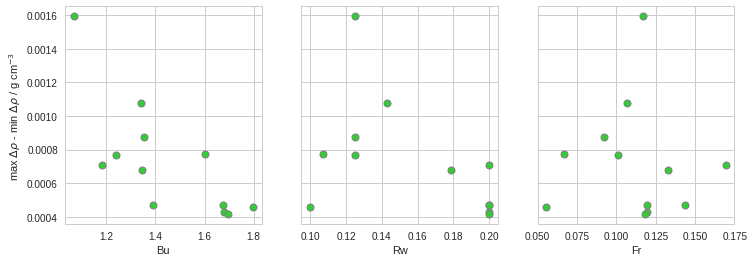

In [45]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for exp, kk in zip(exp_Norder, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    Navg = np.zeros(len(exp['run_files']))
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
        
        Navg[ii] = ((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    W = 5 # cm
    N = np.nanmean(Navg)
    Bu = N*exp["hsb"]/(exp["fo"]*W)
    Rw = exp["U"]/(exp["fo"]*W)
    Fr = exp["U"]/(N*exp["hsb"])
        
    inertial_period = 1/((exp["fo"])/(2*np.pi))
    win = int(inertial_period/dt)
    sca = ax1.plot(Bu,(np.max(filter_timeseries(avg3[0:2400]/(len(exp['run_files'])),winlen=win))-
                       np.min(filter_timeseries(avg3[1000:2400]/(len(exp['run_files'])),winlen=win))),
                   'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
    sca2 = ax2.plot(Rw,(np.max(filter_timeseries(avg3[0:2400]/(len(exp['run_files'])),winlen=win))-
                        np.min(filter_timeseries(avg3[1000:2400]/(len(exp['run_files'])),winlen=win))),
                    'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
    sca3 = ax3.plot(Fr,(np.max(filter_timeseries(avg3[0:2400]/(len(exp['run_files'])),winlen=win))-
                        np.min(filter_timeseries(avg3[1000:2400]/(len(exp['run_files'])),winlen=win))),
                    'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
    
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax3.set_xlabel('Fr')
ax1.set_ylabel(r'max $\Delta \rho$ - min $\Delta \rho$ / g cm$^{-3}$')

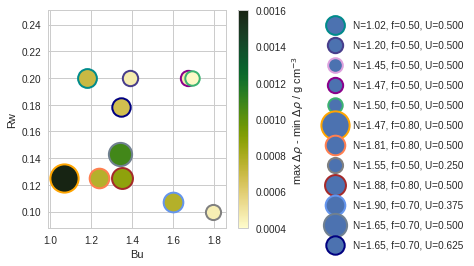

In [47]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4), sharey=True)

for exp, kk in zip(exp_Norder, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    Navg = np.zeros(len(exp['run_files']))
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
        
        Navg[ii] = ((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    W = 5 # cm
    N = np.nanmean(Navg)
    Bu = N*exp["hsb"]/(exp["fo"]*W)
    Rw = exp["U"]/(exp["fo"]*W)
    
    inertial_period = 1/((exp["fo"])/(2*np.pi))
    win = int(inertial_period/dt)
    sca = ax1.scatter(Bu,Rw,
                      s=500000*(np.max(filter_timeseries(avg3[0:2400]/(len(exp['run_files'])),winlen=win))-
                                np.min(filter_timeseries(avg3[1000:2400]/(len(exp['run_files'])),winlen=win))),
                      c=(np.max(filter_timeseries(avg3[0:2400]/(len(exp['run_files'])),winlen=win))-
                         np.min(filter_timeseries(avg3[1000:2400]/(len(exp['run_files'])),winlen=win))),
                      cmap=cmo.cm.speed,
                      vmax=0.0016,
                      vmin=0.0004,
                      marker='o',edgecolors=exp["color"],linewidth=2, 
                      label=('N=%1.2f, f=%1.2f, U=%1.3f' %(exp["Nshelf"],exp["fo"],exp["U"]))) 
  
cb = plt.colorbar(sca)
cb.set_label(r'max $\Delta \rho$ - min $\Delta \rho$ / g cm$^{-3}$')
ax1.set_xlabel('Bu')
ax1.set_ylabel('Rw')
ax1.legend(bbox_to_anchor=(1.5,1),labelspacing=1)           

01Aug19
01Aug19
01Aug19
05Aug19
05Aug19
05Aug19
08Aug19
08Aug19
07Aug19
07Aug19
07Aug19
07Aug19
31Jul19
31Jul19
31Jul19
13Aug19
13Aug19
13Aug19
10Aug19
10Aug19
17Aug19
17Aug19
17Aug19
15Aug19
15Aug19
15Aug19
18Aug19
18Aug19
18Aug19


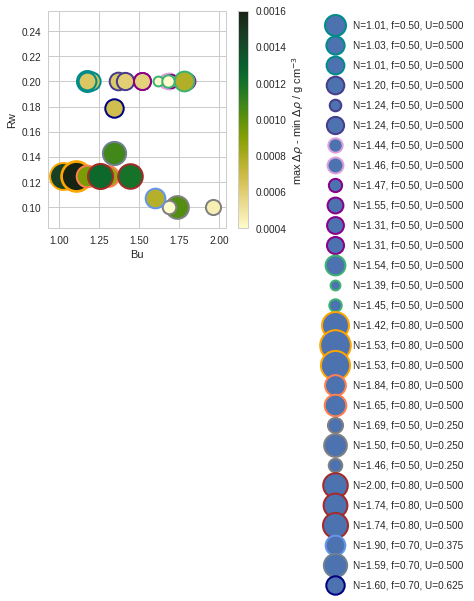

In [24]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4), sharey=True)

for exp, kk in zip(exp_Norder, range(exp_num)):
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        delta = (dens1-dens1[0])-(dens2-dens2[0])
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        print(exp['date'])
        if np.isnan(exp["rho_sb"][ii]) == True:
            N = ((9.81/998.5)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N = ((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        W = 5 # cm
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        tseries = filter_timeseries(delta,winlen=win)
        sca = ax1.scatter(Bu,Rw,
                          s=500000*(np.max(tseries[0:2400])-np.min(tseries[1000:2400])),
                          c=(np.max(tseries[0:2400])-np.min(tseries[1000:2400])),
                          cmap=cmo.cm.speed,
                          vmax=0.0016,
                          vmin=0.0004,
                          marker='o',edgecolors=exp["color"],linewidth=2, 
                          label=('N=%1.2f, f=%1.2f, U=%1.3f' %(N,exp["fo"],exp["U"]))) 
cb = plt.colorbar(sca)
cb.set_label(r'max $\Delta \rho$ - min $\Delta \rho$ / g cm$^{-3}$')
ax1.set_xlabel('Bu')
ax1.set_ylabel('Rw')
ax1.legend(bbox_to_anchor=(1.5,1),labelspacing=1)           

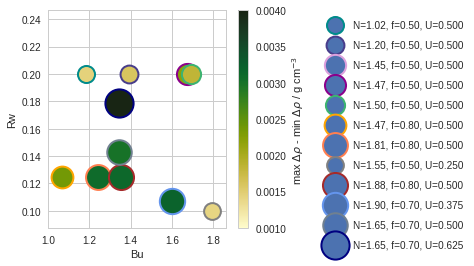

In [38]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4), sharey=True)

for exp, kk in zip(exp_Norder, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    Navg = np.zeros(len(exp['run_files']))
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
        
        Navg[ii] = ((9.81/998.5)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    W = 5 # cm
    N = np.nanmean(Navg)
    Bu = N*exp["hsb"]/(exp["fo"]*W)
    Rw = exp["U"]/(exp["fo"]*W)
        
    inertial_period = 1/((exp["fo"])/(2*np.pi))
    win = int(inertial_period/dt)
    sca = ax1.scatter(Bu,Rw,
                      s=200000*(np.max(filter_timeseries(avg1[0:2400]/(len(exp['run_files'])),winlen=win))),
                      c=(np.max(filter_timeseries(avg1[0:2400]/(len(exp['run_files'])),winlen=win))),
                      cmap=cmo.cm.speed,
                      vmax=0.004,
                      vmin=0.001,
                      marker='o',edgecolors=exp["color"],linewidth=2, 
                      label=('N=%1.2f, f=%1.2f, U=%1.3f' %(exp["Nshelf"],exp["fo"],exp["U"]))) 
cb = plt.colorbar(sca)
cb.set_label(r'max $\Delta \rho$ - min $\Delta \rho$ / g cm$^{-3}$')
ax1.set_xlabel('Bu')
ax1.set_ylabel('Rw')
ax1.legend(bbox_to_anchor=(1.5,1),labelspacing=1)           